# Laboratorium 3 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # w tym pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

arms_number = 50
runs = 50
epochs = 1440
recommendation_size = 10

In [3]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny

arms = {}
for i in range(50):
    activation_probability = uniform(0.01, 0.7)
    mu = uniform(0.1, 2.5)
    sigma = min(uniform(0.1, 1), mu)
    arms['%s' % i] = Arm('%s' % i, activation_probability, lambda: normalvariate(mu, sigma))

arm_ids = list(arms.keys())

In [4]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids,size)
    
    def feedback(self, arm_id, payout):
        pass

In [5]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [6]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [7]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 5921.867913168037
random: 3446.1954905121665


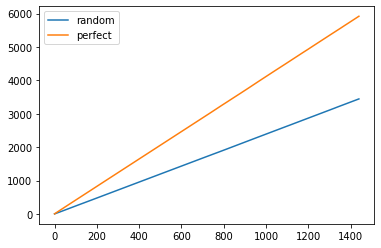

In [8]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 4.185303396282626
random: 2.447295570368202


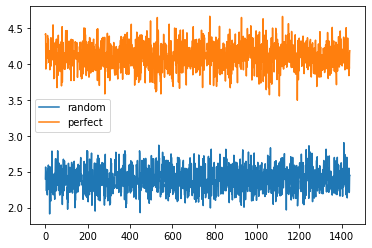

In [9]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [10]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        top_n = [x[0] for x in sorted(self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True)][:size]
        randomized = copy(self.arm_ids)
        shuffle(randomized)
        
        recommendation = []
        i = 0

        while len(recommendation) < size:
            x = uniform(0,1)
            if x > self.epsilon:
                new_item = top_n[i]
            else:
                new_item = randomized[i]
            if not new_item in recommendation:
                recommendation.append(new_item)
                i += 1
                self.recommended_rates[new_item] += 1
            else:
                shuffle(randomized)


        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [11]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        def key(x):
            return x[1] + self.optimism_weight * self._optimism(x[0])
        recommendation = [x[0] for x in sorted(self.payouts_per_recommendation.items(), key=key, reverse=True)][:size]
        for arm in recommendation:
            self.recommended_rates[arm] += 1
        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        sum_n = sum(self.recommended_rates.values())
        n = self.recommended_rates[arm]
        n = n if n > 0 else 1
        result = sqrt(2*log(sum_n)/n) if sum_n > 0 else 0
        return result

In [12]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        def key(x):
            return betavariate( self.a[x],self.b[x])
        recommendation = [x for x in sorted(self.arm_ids, key=key, reverse=True)][:size]
        
        return recommendation
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1 - payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - porównanie bandytów

In [16]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in [(1, 1), (10, 1), (1, 10), (10, 10)]])


In [17]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10



Aggregated results:

perfect: 5926.641977277069
ucb_0.1: 5819.732664984591
ucb_1: 5803.899917405665
ucb_0.01: 4565.683355243814
ucb_10: 4404.080921623374
random: 3446.9524951849216


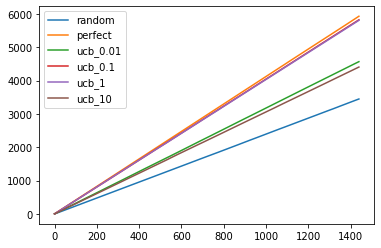

In [18]:
runner.plot_results(results, runs, epochs, mode='cumulative')